In [87]:
from read_data import load_dataset, get_synth_data
import matplotlib.pyplot as plt
#from losses import *
import numpy as np
import pickle
from models.ensemble import Ensemble
from models.dropout import Dropout
from models.evidental import Evidental
from models.evidental_gauss import EvidentalGauss
import tensorflow_probability as tfp
tfd = tfp.distributions

In [88]:
from quantilelosses import quant_evi_loss

In [89]:
def get_hparams(dataset, model):
    # open pickle file
    with open('hparams/' + dataset + '/' + model + '.pickle', 'rb') as handle:
        hparams = pickle.load(handle)
    return hparams['params']


datasets = ['boston', 'concrete', 'energy-efficiency', 'kin8nm', 'naval', 'protein', 'power-plant', 'wine', 'yacht']
models = ['dropout', 'ensemble', 'evidental']

for d in datasets:
    print(d)
    for m in models:
        print(get_hparams(d, m))

boston
{'batch_size': 125.8220338018792, 'dropout': 0.39646617693280706, 'lr': 0.004749986842054625}
{'batch_size': 125.8220338018792, 'dropout': 0.39646617693280706, 'lr': 0.004749986842054625}
{'batch_size': 63.756999096332805, 'dropout': 0.4523105646165684, 'lr': 0.0021473655076930625}
concrete
{'batch_size': 94.0045487869605, 'dropout': 0.2144557339801518, 'lr': 0.0011419887532853736}
{'batch_size': 94.0045487869605, 'dropout': 0.2144557339801518, 'lr': 0.0011419887532853736}
{'batch_size': 65.11855675430206, 'dropout': 0.1402757486459747, 'lr': 0.00042796586411506654}
energy-efficiency
{'batch_size': 65.18456270795963, 'dropout': 0.12854472299430145, 'lr': 0.001779653101206466}
{'batch_size': 65.18456270795963, 'dropout': 0.12854472299430145, 'lr': 0.001779653101206466}
{'batch_size': 65.12009140411794, 'dropout': 0.12387115864382735, 'lr': 0.001996240834098853}
kin8nm
{'batch_size': 98.6592345855439, 'dropout': 0.15477179580908645, 'lr': 0.0014895534219560853}
{'batch_size': 98.6

In [90]:
(x_train, y_train), (x_test, y_test), y_train_mu, y_train_scale = load_dataset("concrete")

Loading dataset concrete....
Done loading dataset concrete


In [91]:
def standardize(data):
    mu = data.mean(axis=0, keepdims=1)
    scale = data.std(axis=0, keepdims=1)
    scale[scale<1e-10] = 1.0

    data = (data - mu) / scale
    return data, mu, scale

In [92]:
def get_dist(which, x):
    return {
        'Gaussian': tfd.Normal(0,2 * abs(x)+0.2),
        'LogGaussian': tfd.LogNormal(0, 0.25*x),
        'Expo': tfd.Exponential(rate=1/(2 * abs(x)+0.2))
    }[which]


def get_synth_data(name = 'Gaussian', x_min=-4, x_max=4, n=1000, quantiles = [0.5], train=True):
    x = np.linspace(x_min, x_max, n)
    x = np.expand_dims(x, -1).astype(np.float32)
    
    sigma = 3 * abs(x)+0.2 if train else np.zeros_like(x)
    dist = get_dist(name, x)
    y = x**3 + dist.sample().numpy().astype(np.float32)    

    return x, y, x**3+dist.quantile(quantiles).numpy().astype(np.float32)


In [93]:
x_train, y_train, y_train_q95 = get_synth_data('Gaussian', x_min=-4,x_max= 4, n=1000, train=True, quantiles=[0.05, 0.95])
x_test, y_test, y_test_q95 = get_synth_data('Gaussian', -4, 4, n=1000, train=True, quantiles=[0.05, 0.95])

x_plot, y_plot,  _ = get_synth_data('Gaussian', -7, 7, n=100, train=True)

x_train, x_train_mu, x_train_scale = standardize(x_train)
x_test = (x_test - x_train_mu) / x_train_scale

x_plot = (x_plot - x_train_mu) / x_train_scale

y_train, y_train_mu, y_train_scale = standardize(y_train)
y_test = (y_test - y_train_mu) / y_train_scale
y_plot = (y_plot - y_train_mu) / y_train_scale


2023-07-05 14:42:35.447314: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /lsf/10.1/linux3.10-glibc2.17-x86_64/lib
2023-07-05 14:42:35.447354: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-05 14:42:35.447405: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gbarlogin1): /proc/driver/nvidia/version does not exist
2023-07-05 14:42:35.448060: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [94]:
#hpara = get_hparams("boston", "evidental")
Evi = Evidental(input_shape=x_train.shape[1:], 
            num_neurons= 128, 
            num_layers=3, 
            lam=0.0,
            activation='leaky_relu',
            drop_prob=0.1,
            coeff=3e-1,
            learning_rate=3e-3,
            patience=250)


eve_g = EvidentalGauss(input_shape=x_train.shape[1:], 
            num_neurons= 128, 
            num_layers=3, 
            lam=0.0,
            activation='leaky_relu',
            drop_prob=0.0,
            learning_rate=3e-3,
            patience=50)

#hpara = get_hparams("boston", "dropout")
Drop = Dropout(input_shape=x_train.shape[1:], 
            num_neurons= 128, 
            num_layers=3, 
            lam=0.0,
            activation='leaky_relu',
            drop_prob=0.1,
            learning_rate=3e-3,
            patience=250)

#hpara = get_hparams("boston", "ensemble")
Ense = Ensemble(input_shape=x_train.shape[1:], 
            num_neurons= 128, 
            num_layers=3, 
            lam=0.0,
            activation='leaky_relu',
            drop_prob=0.1,
            learning_rate=3e-3,
            patience=250)


print(Evi.drop_prob)
print(Drop.drop_prob)
print(Ense.drop_prob)

0.1
0.1
0.1


In [ ]:
#eve_g.train(x_train, y_train, batch_size=128, epochs=1000)
Drop.train(x_train, y_train, batch_size=128, epochs=1000)
#Ense.train(x_train, y_train, batch_size=128, epochs=1000)
Evi.train(x_train, y_train, batch_size=128, epochs=1000)

Restoring model weights from the end of the best epoch: 448.
Epoch 698: early stopping
Restoring model weights from the end of the best epoch: 107.
Epoch 357: early stopping


In [ ]:
print("Evidence: ", Evi.evaluate(x_train, y_train, y_train_mu, y_train_scale))
print("Dropout: ", Drop.evaluate(x_train, y_train, y_train_mu, y_train_scale))
print("Ensemble: ", Ense.evaluate(x_train, y_train, y_train_mu, y_train_scale))

print("Evidence: ", Evi.evaluate(x_test, y_test, y_train_mu, y_train_scale))
print("Dropout: ", Drop.evaluate(x_test, y_test, y_train_mu, y_train_scale))
print("Ensemble: ", Ense.evaluate(x_test, y_test, y_train_mu, y_train_scale))

Evidence:  (1.0650752, 6.610282, 0.0046331524848937985)
Dropout:  (1.1032786, 6.493363, 0.050903069972991946)
Ensemble:  (16.7198, 12.770166, 0.021000874042510987)
Evidence:  (1.0101856, 6.348961, 0.004630446434020996)
Dropout:  (1.0882624, 6.48822, 0.049761271476745604)
Ensemble:  (16.395922, 12.751462, 0.021569013595581055)


In [ ]:
#plt.plot(Evi.history.history['val_nll_eval'], c='red', linestyle='--')
#plt.plot(Evi.history.history['nll_eval'], c='red', label='Evidental')
#plt.plot(Drop.history.history['val_loss'], c='blue', linestyle='--')
#plt.plot(Drop.history.history['loss'], c='blue', label='Dropout')
#plt.plot(eve_g.history.history['val_loss'], c='blue', linestyle='--')
#plt.plot(eve_g.history.history['loss'], c='blue', label='Dropout')
#plt.plot(Ense.history[0].history['val_loss'], c='green', linestyle='--')
#plt.plot(Ense.history[0].hi
# story['loss'], c='green', label='Ensemble')
#plt.legend()
#plt.show()
#plt.plot(Evi.history.history['val_loss'], c='red', linestyle='--')
#plt.plot(Evi.history.history['loss'], c='red', label='Evidental')
#plt.show()

In [ ]:
evi_preds = Evi.predict(x_test)
drop_preds = Drop.predict(x_test)
ense_preds = Ense.predict(x_test)

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
output = eve_g.model(x_test)
mu, v, alpha, beta = tf.split(output, 4, axis=-1)

In [ ]:
dist = tfd.Normal(loc=(mu*y_train_scale) + y_train_mu, scale=y_train_scale*np.sqrt(beta/(v*(alpha-1))))

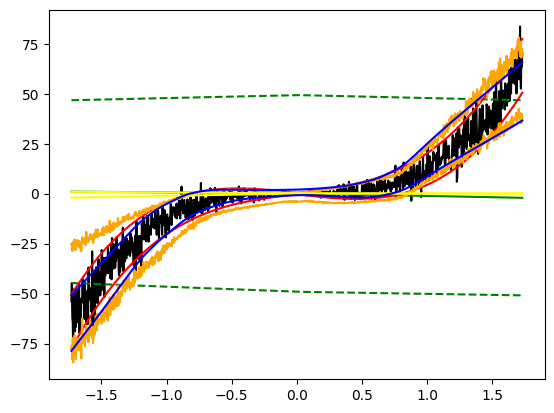

In [ ]:
plt.plot(x_test, y_test* y_train_scale + y_train_mu, c='black')
#plt.plot(x_test, mu)
#plt.plot(x_test, mu + 2*np.sqrt(beta/(v*(alpha-1))))
#plt.plot(x_test, mu - 2*np.sqrt(beta/(v*(alpha-1))))
plt.plot(x_test, dist.mean(), c='green')
plt.plot(x_test, dist.quantile([0.95]), '--', c='green')
plt.plot(x_test, dist.quantile([0.05]), '--', c='green')
plt.plot(x_test, y_test_q95[:,0], c='red')
plt.plot(x_test, y_test_q95[:,1], c='red')
plt.plot(x_test, tf.expand_dims(drop_preds[:,1],1)* y_train_scale + y_train_mu, c='orange')
plt.plot(x_test, tf.expand_dims(drop_preds[:,0],1)* y_train_scale + y_train_mu, c='orange')
plt.plot(x_test, tf.expand_dims(ense_preds[:,1],1)* y_train_scale + y_train_mu, c='yellow')
plt.plot(x_test, tf.expand_dims(ense_preds[:,0],1)* y_train_scale + y_train_mu, c='yellow')
plt.plot(x_test, tf.expand_dims(evi_preds[:,1],1)* y_train_scale + y_train_mu, c='blue')
plt.plot(x_test, tf.expand_dims(evi_preds[:,0],1)* y_train_scale + y_train_mu, c='blue')
#plt.ylim(-5, 75)

In [ ]:
errors_evi = (y_test_q95-(evi_preds* y_train_scale + y_train_mu))
errors_drop = (y_test_q95-(drop_preds* y_train_scale + y_train_mu))
#errors_gauss = (y_test_q95-(dist.quantile([0.05, 0.95])))

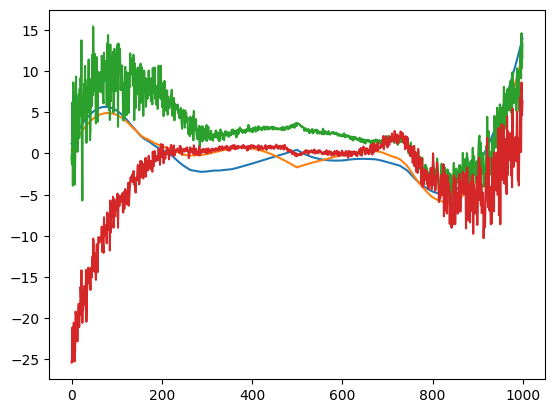

In [ ]:
plt.plot(errors_evi)
plt.plot(errors_drop)

In [ ]:
expected = np.arange(41)/40
def plot_(model, label, axis, evi=False):
    expected = np.arange(101)/100
    #sigma = model.get_uncertainties(x_train)[:,1]
    #mu = model.predict(x_train)[:,1]
    mu, _ = model.get_mu_sigma(x_test)
    mu = (mu*y_train_scale) + y_train_mu
    mu = mu[:,axis]
    sigma = model.get_uncertainties(x_test)*y_train_scale
    sigma = sigma[:,axis]
    #if evi:
        #sigma = tf.math.sqrt(sigma)
    pred_dist = tfp.distributions.Normal(loc=mu, scale=sigma)
    target = y_test_q95[:,axis]
    obs_p_list = []
    #plt.plot(mu)
    #plt.plot(mu+sigma)
    #plt.plot(mu-sigma)
    #plt.plot(target, c='black')
    #plt.show()
    for p in expected:
        ppf = pred_dist.quantile(p)
        obs_p = (target < ppf).numpy().mean()
        obs_p_list.append(obs_p)

    calibration_error =  np.abs(expected - obs_p_list).mean()
    print(calibration_error)
    plt.plot(expected, obs_p_list,label=label)

    #plt.plot(expected, expected, c='black', linestyle='--')
    #plt.show()

0.10821782178217822
0.32607920792079215
0.28897029702970295


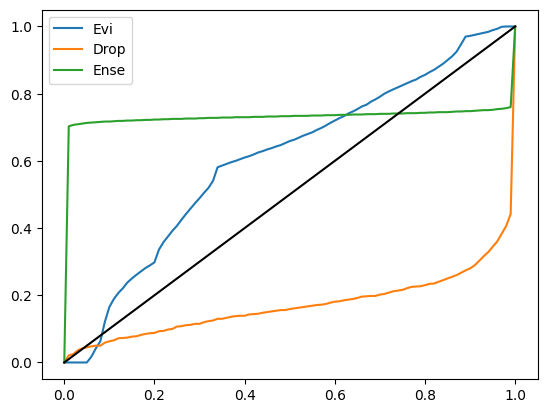

In [ ]:
axis = 0
plot_(Evi, label='Evi', axis=axis, evi=True)
plot_(Drop, label='Drop', axis=axis)
plot_(Ense, label='Ense', axis=axis)
plt.plot(expected, expected, c='black')
plt.legend()

In [ ]:
mu, _ = Evi.get_mu_sigma(x_plot)
mu = (mu*y_train_scale) + y_train_mu
mu = mu[:,axis]
sigma = Evi.get_uncertainties(x_plot)*y_train_scale
sigma = sigma[:,axis]
#if evi:
    #sigma = tf.math.sqrt(sigma)
pred_dist = tfp.distributions.Normal(loc=mu, scale=sigma)
target = y_test_q95[:,axis]
obs_p_list = []
#plt.plot(mu)
#plt.plot(mu+sigma)
#plt.plot(mu-sigma)
#plt.plot(target, c='black')
#plt.show()
for p in expected:
    ppf = pred_dist.quantile(p)
    obs_p = (target < ppf).numpy().mean()
    obs_p_list.append(obs_p)

InvalidArgumentError: {{function_node __wrapped__Greater_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [100] vs. [1000] [Op:Greater]

In [ ]:
entropy = tf.expand_dims(0.5*np.log(2*np.pi*np.exp(1.)*(sigma**2)),1)

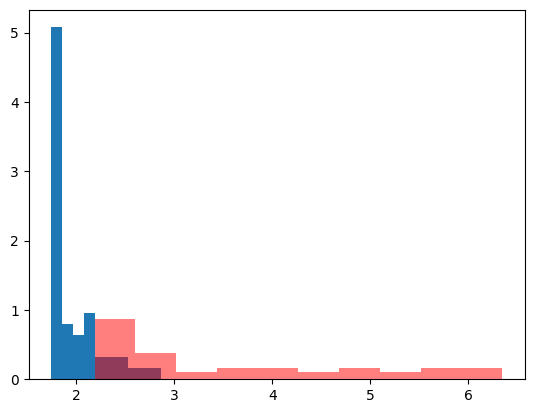

In [ ]:
plt.hist(entropy[(((x_plot*x_train_scale) + x_train_mu) > -4.0) & (((x_plot*x_train_scale) + x_train_mu) < 4.0)], density=True)
plt.hist(entropy[(((x_plot*x_train_scale) + x_train_mu) < -4.0) | (((x_plot*x_train_scale) + x_train_mu) > 4.0)], color='red', alpha=0.5, density=True)
plt.show()

In [ ]:
unc_ = np.linspace(entropy[tf.argmin(entropy)[0].numpy()], entropy[tf.argmax(entropy)[0].numpy()], 100)

In [ ]:
import scipy

In [ ]:
unc.shape

(1000,)

In [ ]:
unc = np.sort(entropy.numpy().flatten())
prob = np.linspace(0,1, unc.shape[0])
f_cdf = scipy.interpolate.interp1d(unc, prob, fill_value=(0.,1.), bounds_error=False)
prob_ = f_cdf(unc)

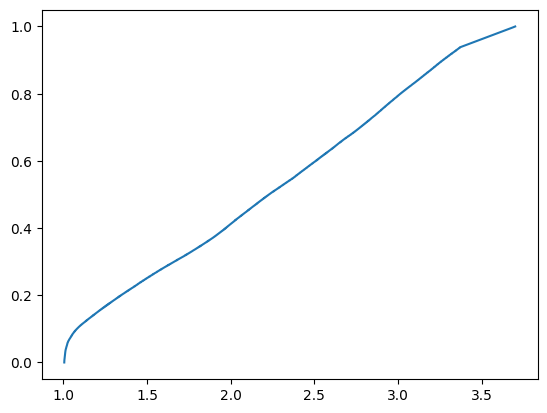

In [ ]:
plt.plot(unc, prob_)

In [ ]:
print("Evidence")
for i, q in enumerate(Evi.quantiles):
    print("The q is {} model have {}".format(q, (y_test<tf.expand_dims(evi_preds[:,i],1)).numpy().mean()))

print("Dropout")
for i, q in enumerate(Evi.quantiles):
    print("The q is {} model have {}".format(q, (y_test<tf.expand_dims(drop_preds[:,i],1)).numpy().mean()))

print("Ensemble")
for i, q in enumerate(Evi.quantiles):
    print("The q is {} model have {}".format(q, (y_test<tf.expand_dims(ense_preds[:,i],1)).numpy().mean()))


Evidence
The q is 0.05 model have 0.064
The q is 0.95 model have 0.939
Dropout
The q is 0.05 model have 0.024
The q is 0.95 model have 0.965
Ensemble
The q is 0.05 model have 0.048
The q is 0.95 model have 0.955


In [ ]:
#print(tf.reduce_mean(y_test-tf.expand_dims(evi_preds[:,1],1)**2))
#print(tf.reduce_mean(y_test-tf.expand_dims(drop_preds[:,1],1)**2))
#print(tf.reduce_mean(y_test-tf.expand_dims(ense_preds[:,1],1)**2))

In [ ]:
#plt.figure(figsize=(10,10))
#plt.plot(y_test)
#plt.plot(evi_preds[:,0], label='Evidential')
#plt.plot(drop_preds[:,0], label='Evidential')
#plt.scatter(y_test, evi_preds[:,1], label='Evidential')
#plt.scatter(y_test, drop_preds[:,1], label='Dropout')
#plt.scatter(y_test, ense_preds[:,1], label='Ensemble')
#plt.plot(y_test, y_test, label='Ground Truth')
#plt.legend()

In [ ]:
def plot_q(x_train, y_train, x_test, y_test, model):
    #mu, var_ = model.get_mu_sigma(x_test)
    mu = model.predict(x_test)
    var_ = model.get_uncertainties(x_test)
    mu = (mu*y_train_scale) + y_train_mu
    var_ = var_*y_train_scale
    y_test = (y_test*y_train_scale) + y_train_mu
    y_train = (y_train*y_train_scale) + y_train_mu
    x_train = (x_train*x_train_scale) + x_train_mu
    x_test = (x_test*x_train_scale) + x_train_mu
    for i, q in enumerate(model.quantiles):
        plot_predictions(x_train, y_train, x_test, y_test, mu[:,i], var=var_[:,i], quantile=q, n_stds=4, kk=i)

def plot_predictions(x_train, y_train, x_test, y_test, y_pred, var, quantile, n_stds=4, kk=0):
    x_test = x_test[:, 0]
    x_train = x_train[:, 0]
    #var = np.minimum(var, 1e3)  # for visualization
    plt.figure(figsize=(5, 3), dpi=200)
    plt.title("Quantile: {:.2f}".format(quantile))
    plt.scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
    #plt.plot(x_test, y_test, 'r--', zorder=2, label="True")
    plt.scatter(x_test, y_test, c='r',s=1., zorder=2, label="True")
    plt.plot(x_test, y_pred, color='#007cab', zorder=3, label="Pred")
    #plt.plot(x_test, mu_z, color='green', zorder=3, label="Pred_or")
    #plt.plot(x_test, mu_z+2*std_z, color='green', linestyle='--', zorder=3, label="Pred_or")
    plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)

    for k in np.linspace(0, n_stds, 4):
        #print(var.shape)
        #print(mu.shape)
        #print((k*var).shape)
        plt.fill_between(
            x_test, (y_pred - k * var), (y_pred + k * var),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc." if k == 0 else None)
    plt.gca().set_ylim(-150, 150)
    #plt.gca().set_ylim(-5, 5)
    plt.gca().set_xlim(-7, 7)
    plt.legend(loc="upper left")
    plt.show()


Evidence


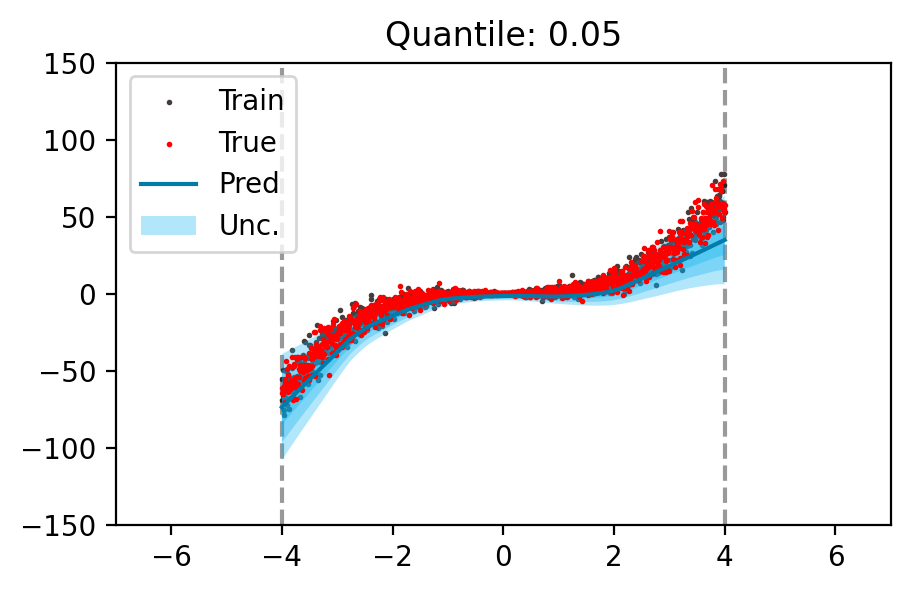

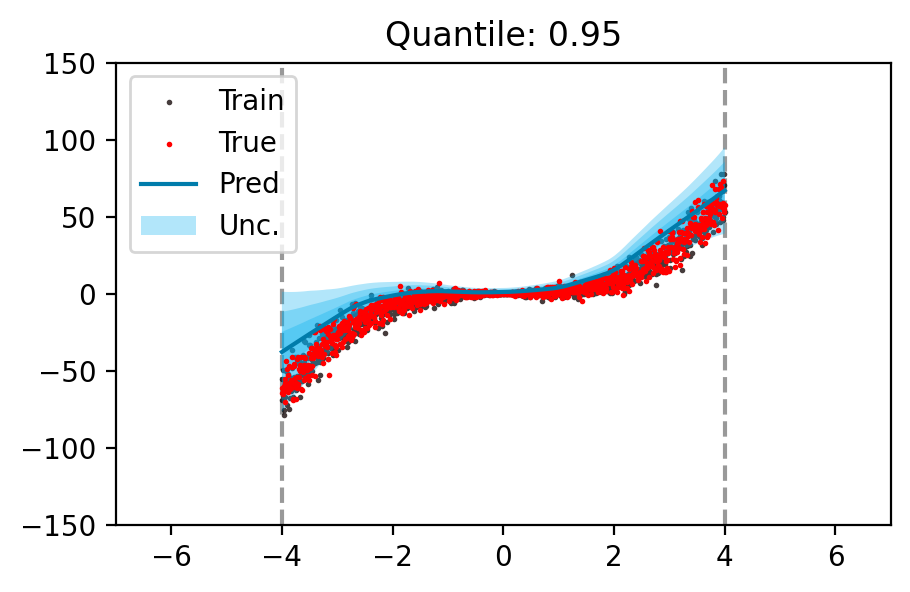

Dropout


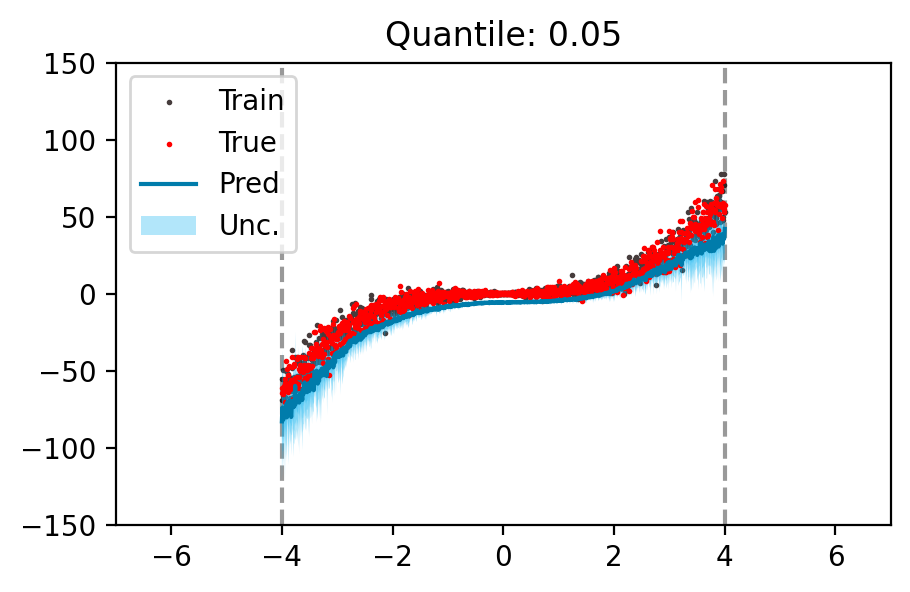

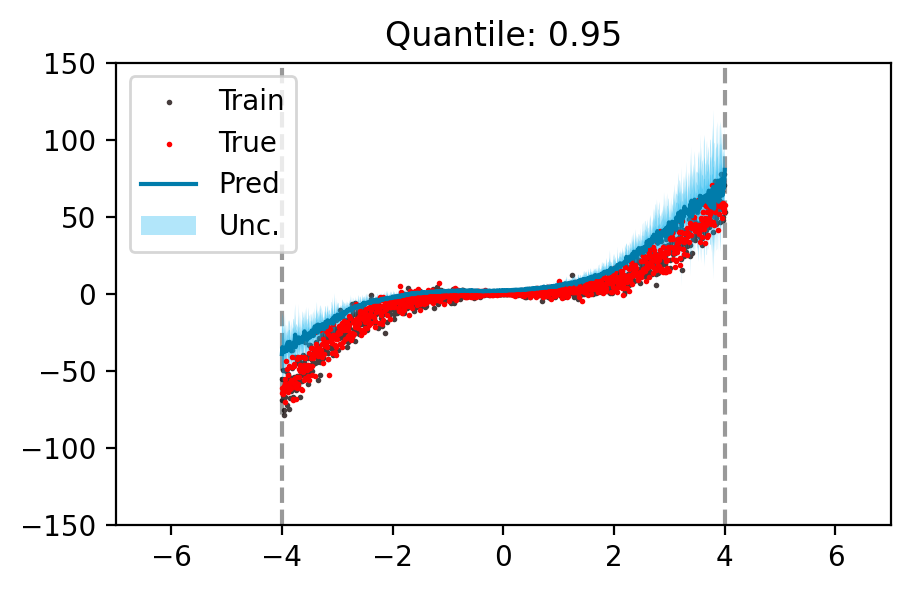

Ensemble


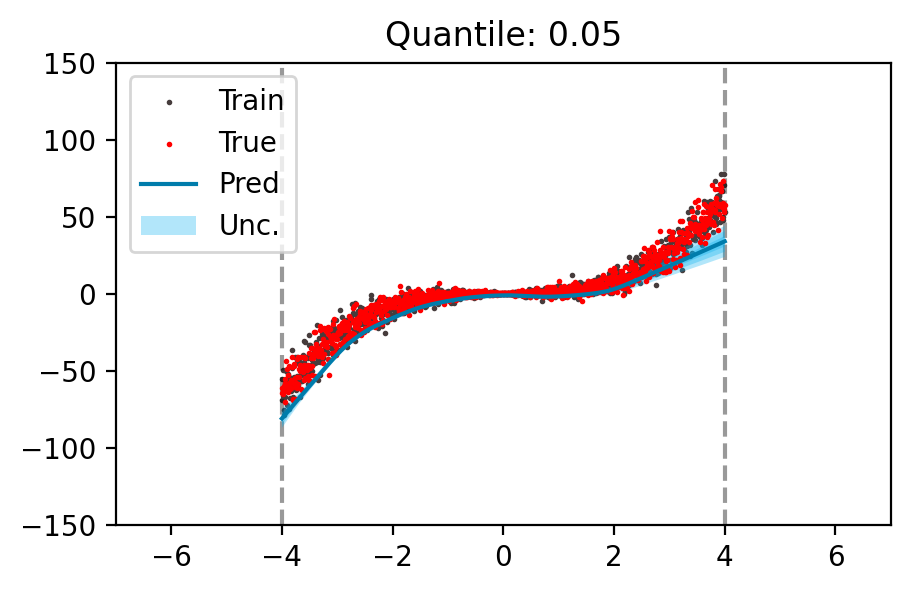

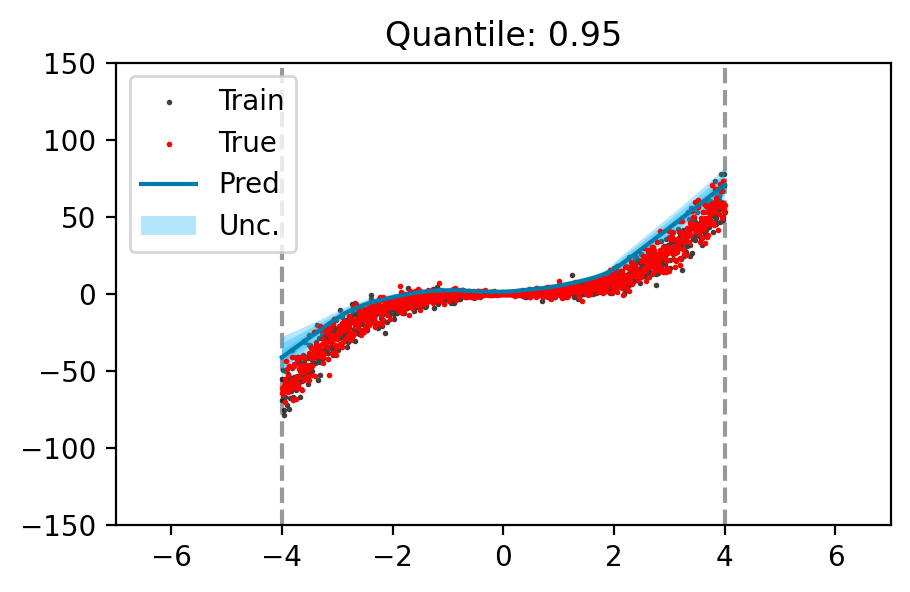

In [ ]:
print("Evidence")
plot_q(x_train, y_train, x_test, y_test, Evi)
print("Dropout")
plot_q(x_train, y_train, x_test, y_test, Drop)
print("Ensemble")
plot_q(x_train, y_train, x_test , y_test, Ense)


Evidence


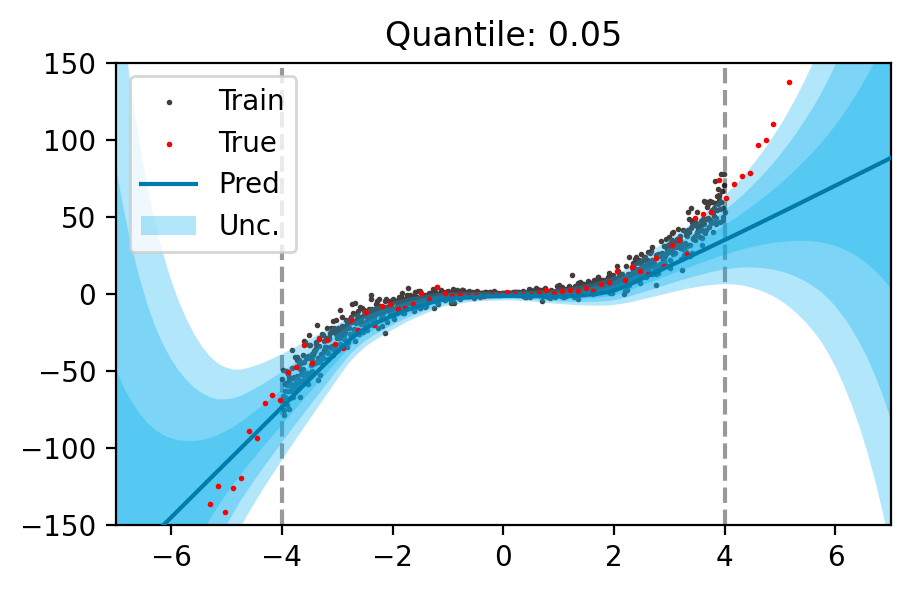

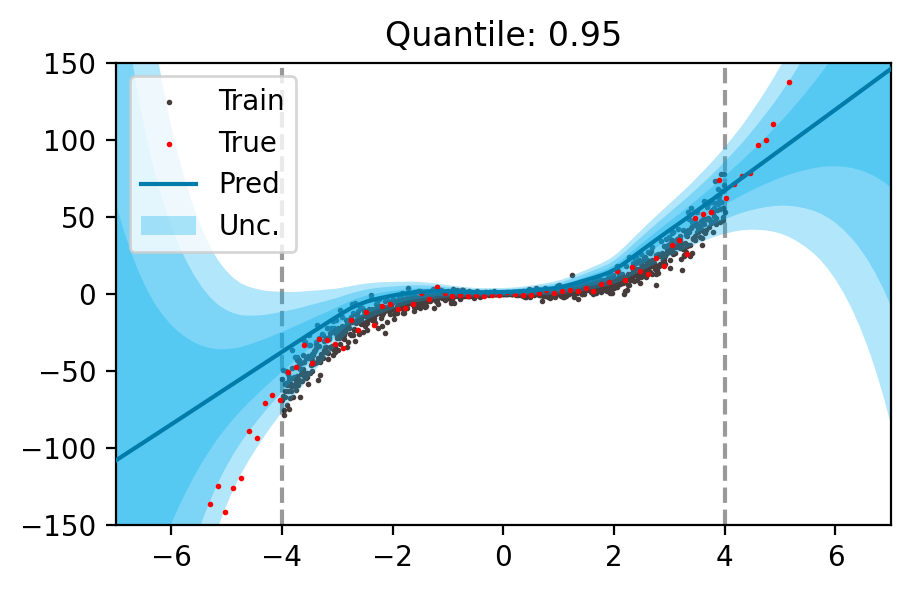

Dropout


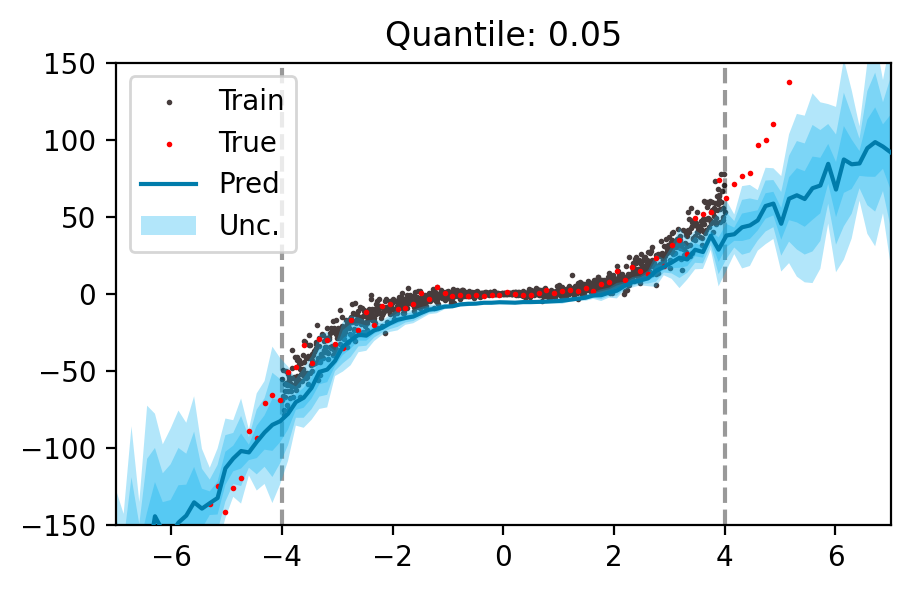

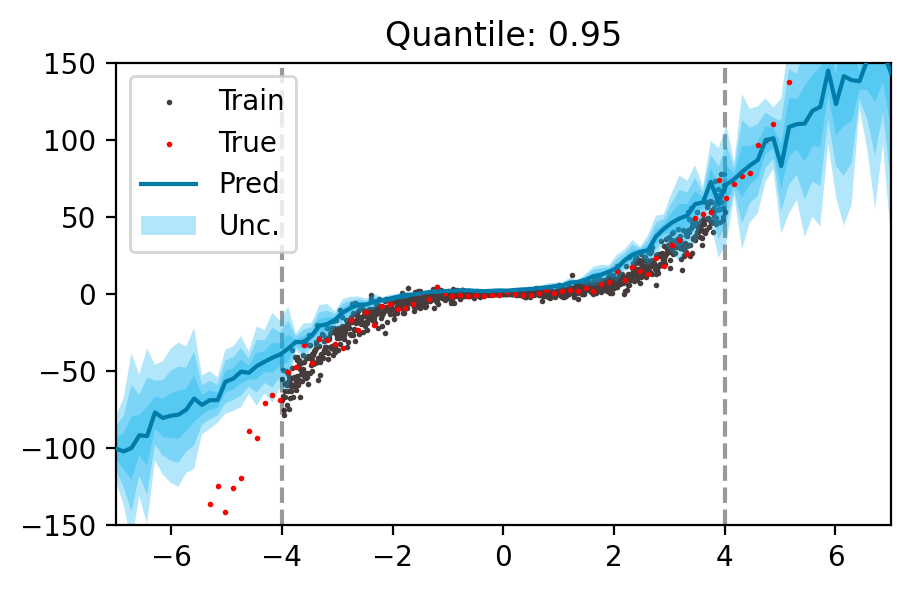

Ensemble


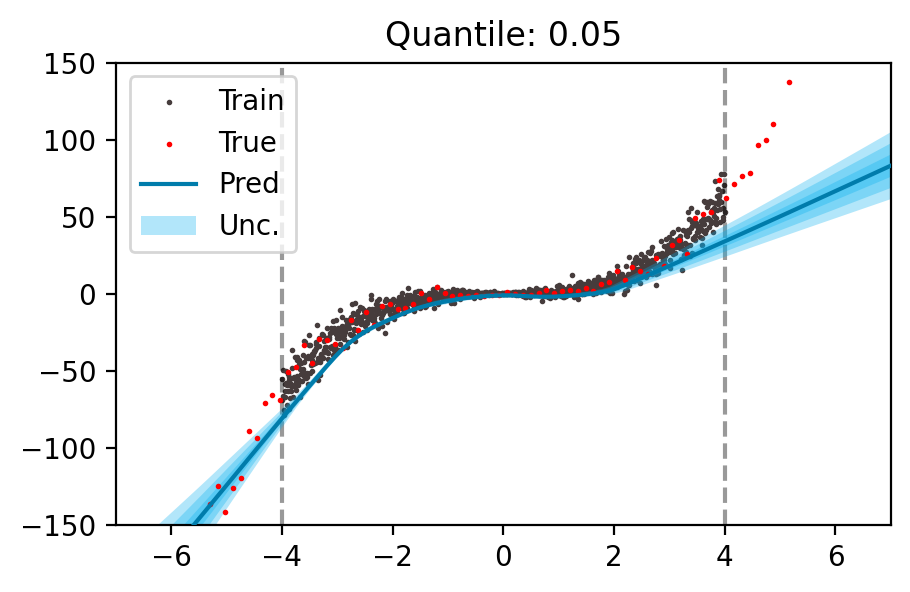

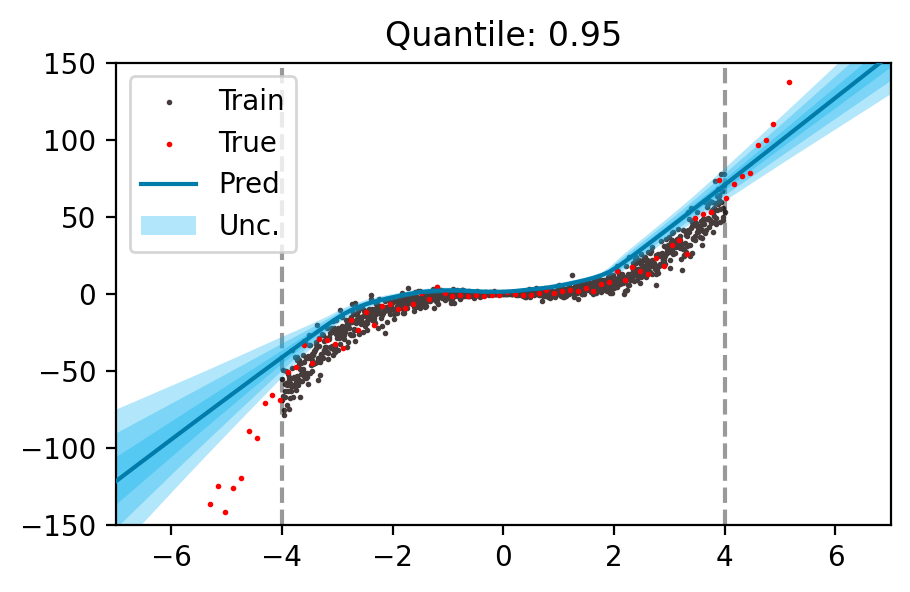

In [ ]:
print("Evidence")
plot_q(x_train, y_train, x_plot, y_plot, Evi)
print("Dropout")
plot_q(x_train, y_train, x_plot, y_plot, Drop)
print("Ensemble")
plot_q(x_train, y_train, x_plot, y_plot, Ense)

In [2]:
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from models.evidentalconv import ConvEvidental
from quantilelosses import *
import pickle

In [3]:
test = h5py.File("data/depth/depth_test.h5", "r")
ood = h5py.File('data/depth/apolloscape_test.h5', 'r')

In [4]:
x_test, y_test = (test["image"], test["depth"])
ood_x, ood_y = (ood["image"], ood["depth"])

In [5]:
evidental = h5py.File("results/depth/evidental_1.h5", "r")
dropout = h5py.File("results/depth/dropout_1.h5", "r")

In [6]:
print(evidental.keys())
print(dropout.keys())

<KeysViewHDF5 ['in_dist_mu', 'in_dist_sigma', 'in_dist_unc', 'out_dist_mu', 'out_dist_sigma', 'out_dist_unc']>
<KeysViewHDF5 ['in_dist_mu', 'in_dist_sigma', 'in_dist_unc', 'out_dist_mu', 'out_dist_sigma', 'out_dist_unc']>


In [15]:
def parse_ensemble():
    ensemble_1 = h5py.File("results/depth/ensemble_1.h5", "r")
    ensemble_2 = h5py.File("results/depth/ensemble_2.h5", "r")
    ensemble_3 = h5py.File("results/depth/ensemble_3.h5", "r")
    ensemble_4 = h5py.File("results/depth/ensemble_4.h5", "r")
    ensemble_5 = h5py.File("results/depth/ensemble_5.h5", "r")

    return {
        'in_dist_mu': get_mu('in_dist_mu', ensemble_1, ensemble_2, ensemble_3, ensemble_4, ensemble_5),
        'out_dist_mu': get_mu('out_dist_mu', ensemble_1, ensemble_2, ensemble_3, ensemble_4, ensemble_5),
        'in_dist_sigma': get_mu('in_dist_sigma', ensemble_1, ensemble_2, ensemble_3, ensemble_4, ensemble_5),
        'out_dist_sigma': get_mu('out_dist_sigma', ensemble_1, ensemble_2, ensemble_3, ensemble_4, ensemble_5),
        'in_dist_unc': get_std('in_dist_mu', ensemble_1, ensemble_2, ensemble_3, ensemble_4, ensemble_5),
        'out_dist_unc': get_std('out_dist_mu', ensemble_1, ensemble_2, ensemble_3, ensemble_4, ensemble_5)
    }
    

In [16]:
def get_mu(colname, ensemble_1, ensemble_2, ensemble_3, ensemble_4, ensemble_5):
    ense_1 = ensemble_1[colname][:]
    ense_2 = ensemble_2[colname][:]
    ense_3 = ensemble_3[colname][:]
    ense_4 = ensemble_4[colname][:]
    ense_5 = ensemble_5[colname][:]
    return np.mean([ense_1, ense_2, ense_3, ense_4, ense_5], axis=0)

def get_std(colname, ensemble_1, ensemble_2, ensemble_3, ensemble_4, ensemble_5):
    ense_1 = ensemble_1[colname][:]
    ense_2 = ensemble_2[colname][:]
    ense_3 = ensemble_3[colname][:]
    ense_4 = ensemble_4[colname][:]
    ense_5 = ensemble_5[colname][:]
    return np.std([ense_1, ense_2, ense_3, ense_4, ense_5], axis=0)

In [17]:
ensemble = parse_ensemble()

In [18]:
print(evidental.keys())
print(dropout.keys())

<KeysViewHDF5 ['in_dist_mu', 'in_dist_sigma', 'in_dist_unc', 'out_dist_mu', 'out_dist_sigma', 'out_dist_unc']>
<KeysViewHDF5 ['in_dist_mu', 'in_dist_sigma', 'in_dist_unc', 'out_dist_mu', 'out_dist_sigma', 'out_dist_unc']>


In [19]:
# combine predictions from all the ensembles


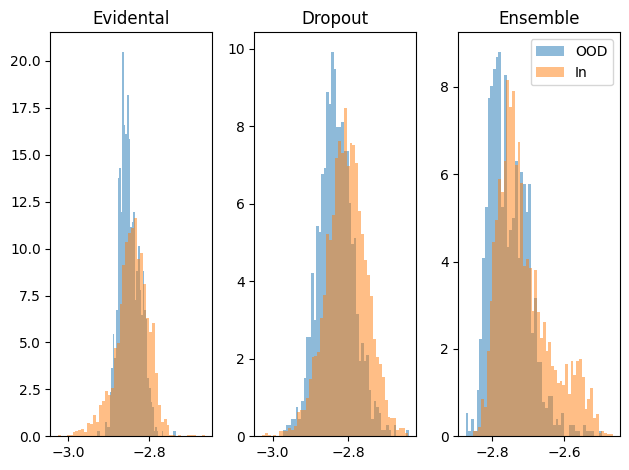

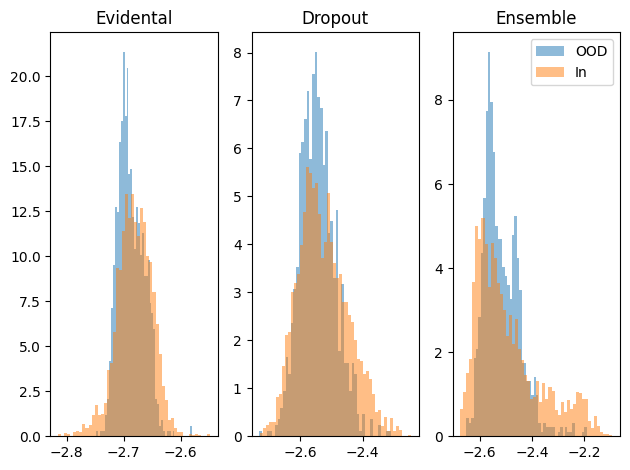

In [20]:
ev_ood_unc = np.mean(evidental['out_dist_sigma'], axis=(1, 2))
ev_in_unc = np.mean(evidental['in_dist_sigma'], axis=(1, 2))

dr_ood_unc = np.mean(dropout['out_dist_sigma'], axis=(1, 2))
dr_in_unc = np.mean(dropout['in_dist_sigma'], axis=(1, 2))

en_ood_unc = np.mean(ensemble['out_dist_sigma'], axis=(1, 2))
en_in_unc = np.mean(ensemble['in_dist_sigma'], axis=(1, 2))

ev_ood_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(ev_ood_unc**2))
ev_in_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(ev_in_unc**2))

dr_ood_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(dr_ood_unc**2))
dr_in_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(dr_in_unc**2))

en_ood_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(en_ood_unc**2))
en_in_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(en_in_unc**2))

for i in range(2):
    # make 3 histogram side by side
    fig, axs = plt.subplots(1, 3, sharey=False, tight_layout=True)

    axs[0].hist(ev_ood_entr[:,i], bins=50, alpha=0.5, label='OOD', density=True)
    axs[0].hist(ev_in_entr[:,i], bins=50, alpha=0.5, label='In', density=True)
    axs[0].set_title('Evidental')

    axs[1].hist(dr_ood_entr[:,i], bins=50, alpha=0.5, label='OOD', density=True)
    axs[1].hist(dr_in_entr[:,i], bins=50, alpha=0.5, label='In', density=True)
    axs[1].set_title('Dropout')

    axs[2].hist(en_ood_entr[:,i], bins=50, alpha=0.5, label='OOD', density=True)
    axs[2].hist(en_in_entr[:,i], bins=50, alpha=0.5, label='In', density=True)
    axs[2].set_title('Ensemble')

    plt.legend()
    plt.show()

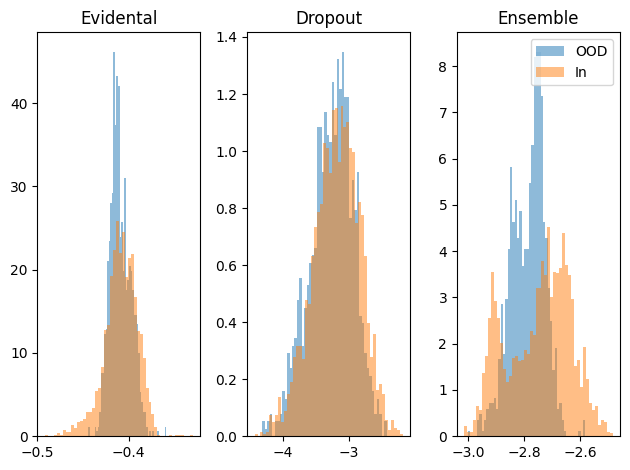

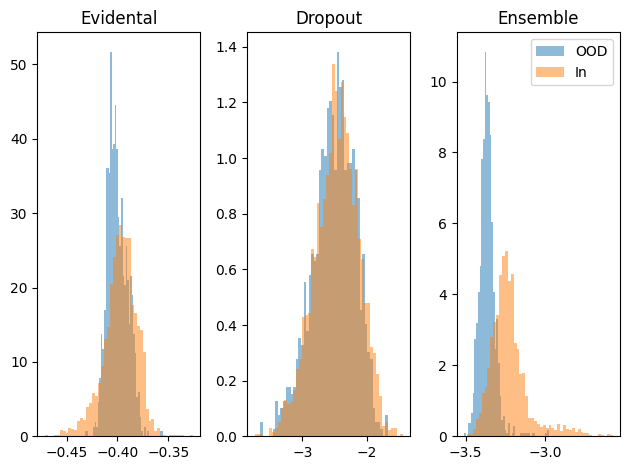

In [21]:
ev_ood_unc = np.mean(evidental['out_dist_unc'], axis=(1, 2))
ev_in_unc = np.mean(evidental['in_dist_unc'], axis=(1, 2))

dr_ood_unc = np.mean(dropout['out_dist_unc'], axis=(1, 2))
dr_in_unc = np.mean(dropout['in_dist_unc'], axis=(1, 2))

en_ood_unc = np.mean(ensemble['out_dist_unc'], axis=(1, 2))
en_in_unc = np.mean(ensemble['in_dist_unc'], axis=(1, 2))

ev_ood_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(ev_ood_unc**2))
ev_in_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(ev_in_unc**2))

dr_ood_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(dr_ood_unc**2))
dr_in_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(dr_in_unc**2))

en_ood_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(en_ood_unc**2))
en_in_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(en_in_unc**2))

for i in range(2):
    # make 3 histogram side by side
    fig, axs = plt.subplots(1, 3, sharey=False, tight_layout=True)

    axs[0].hist(ev_ood_entr[:,i], bins=50, alpha=0.5, label='OOD', density=True)
    axs[0].hist(ev_in_entr[:,i], bins=50, alpha=0.5, label='In', density=True)
    axs[0].set_title('Evidental')

    axs[1].hist(dr_ood_entr[:,i], bins=50, alpha=0.5, label='OOD', density=True)
    axs[1].hist(dr_in_entr[:,i], bins=50, alpha=0.5, label='In', density=True)
    axs[1].set_title('Dropout')

    axs[2].hist(en_ood_entr[:,i], bins=50, alpha=0.5, label='OOD', density=True)
    axs[2].hist(en_in_entr[:,i], bins=50, alpha=0.5, label='In', density=True)
    axs[2].set_title('Ensemble')

    plt.legend()
    plt.show()

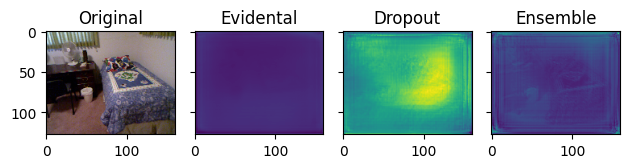

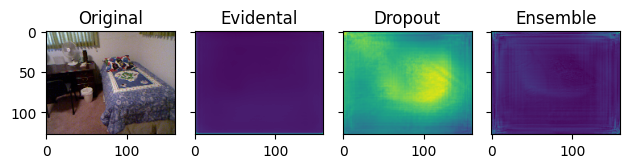

In [22]:
# create 3 side by side images of the uncertainty
image_id = 1
for i in range(2):
    fig, axs = plt.subplots(1,4, sharey=True, tight_layout=True)

    axs[0].imshow(x_test[image_id,:,:])
    axs[0].set_title('Original')

    axs[1].imshow(evidental['in_dist_unc'][image_id,:,:,i]*np.float64(255.))
    axs[1].set_title('Evidental')

    axs[2].imshow(dropout['in_dist_unc'][image_id,:,:,i])
    axs[2].set_title('Dropout')

    axs[3].imshow(ensemble['in_dist_unc'][image_id,:,:,i])
    axs[3].set_title('Ensemble')

    plt.show()

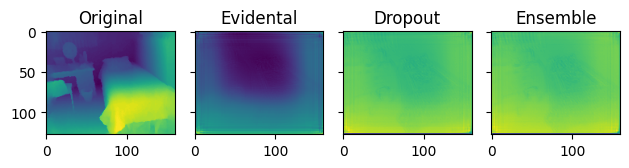

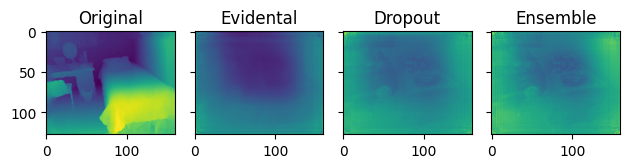

In [23]:
# create 3 side by side images of the uncertainty
for i in range(2):
    fig, axs = plt.subplots(1,4, sharey=True, tight_layout=True)

    axs[0].imshow(y_test[image_id,:,:])
    axs[0].set_title('Original')

    axs[1].imshow(evidental['in_dist_mu'][image_id,:,:,i])
    axs[1].set_title('Evidental')
    axs[2].imshow(dropout['in_dist_mu'][image_id,:,:,i])
    axs[2].set_title('Dropout')
    axs[3].imshow(ensemble['in_dist_mu'][image_id,:,:,i])
    axs[3].set_title('Ensemble')
    plt.show()

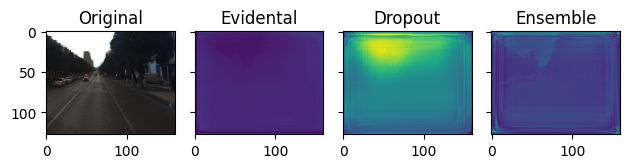

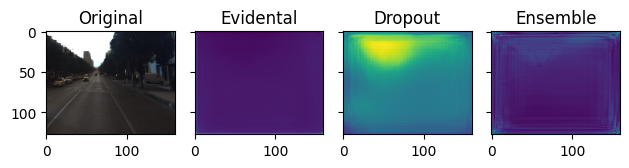

In [24]:
# create 3 side by side images of the uncertainty
image_id = 1
for i in range(2):
    fig, axs = plt.subplots(1,4, sharey=True, tight_layout=True)

    axs[0].imshow(ood_x[image_id,:,:])
    axs[0].set_title('Original')

    axs[1].imshow(evidental['out_dist_unc'][image_id,:,:,i]*np.float64(255.))
    axs[1].set_title('Evidental')

    axs[2].imshow(dropout['out_dist_unc'][image_id,:,:,i])
    axs[2].set_title('Dropout')

    axs[3].imshow(ensemble['out_dist_unc'][image_id,:,:,i])
    axs[3].set_title('Ensemble')

    plt.show()

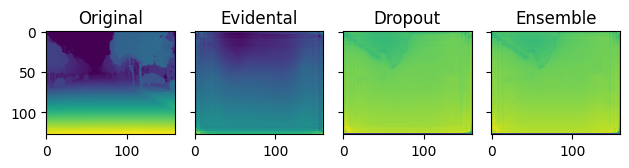

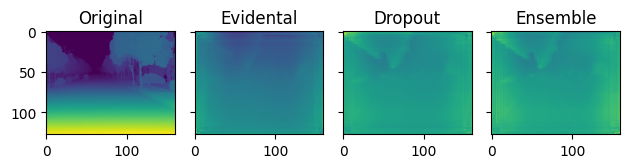

In [25]:
# create 3 side by side images of the uncertainty
for i in range(2):
    fig, axs = plt.subplots(1,4, sharey=True, tight_layout=True)

    axs[0].imshow(ood_y[image_id,:,:])
    axs[0].set_title('Original')

    axs[1].imshow(evidental['out_dist_mu'][image_id,:,:,i])
    axs[1].set_title('Evidental')
    axs[2].imshow(dropout['out_dist_mu'][image_id,:,:,i])
    axs[2].set_title('Dropout')
    axs[3].imshow(ensemble['out_dist_mu'][image_id,:,:,i])
    axs[3].set_title('Ensemble')
    plt.show()

In [37]:
import  pickle
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

In [38]:
with open('results/synth/Gaussian_evidental1.pickle', 'rb') as handle:
    res = pickle.load(handle)

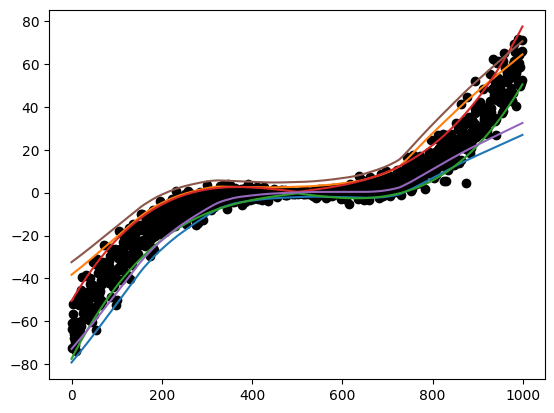

In [39]:
plt.plot(res['test_mu'],'o', c='black')
plt.plot(res['mu'])
plt.plot(res['test'])
plt.plot(res['mu'] + 2*np.sqrt(res['sigma']))

In [40]:
expected = np.arange(41)/40
def plot_(mu, sigma, test, label, axis, evi=False):
    mu = mu[:,axis]
    sigma = sigma[:,axis]
    expected = np.arange(101)/100
    pred_dist = tfp.distributions.Normal(loc=mu, scale=sigma)
    target = test[:,axis]
    obs_p_list = []
    for p in expected:
        ppf = pred_dist.quantile(p)
        obs_p = (target < ppf).numpy().mean()
        obs_p_list.append(obs_p)

    calibration_error =  np.abs(expected - obs_p_list).mean()
    print(calibration_error)
    plt.plot(expected, obs_p_list,label=label)

    plt.plot(expected, expected, c='black', linestyle='--')
    #plt.show()

0.17465346534653467
0.1554257425742574


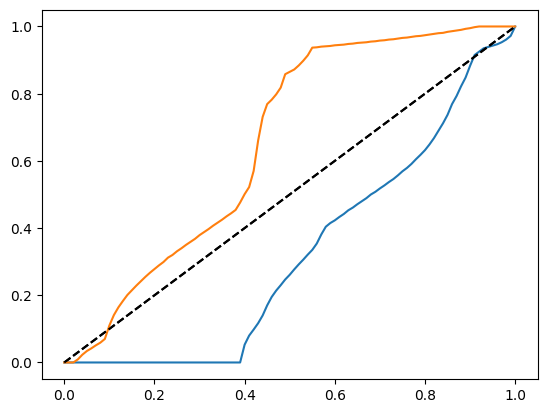

In [41]:
plot_(res['mu'], res['sigma'],res['test'], 'Evidental', 0)
plot_(res['mu'], res['sigma'],res['test'], 'Evidental', 1)